# hypothesis 4: congresspeople use religious code more during religious seasons

# load data and imports

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os

tqdm.pandas()

In [90]:
DATA_PATH = "/data/laviniad/congress_errata/congress_df.json"
df = pd.read_json(DATA_PATH)
df['date'] = pd.to_datetime(df['date'].apply(str), format='%Y%m%d')
df['month'] = df['date'].dt.month

In [94]:
raw_df = df.copy()

# filter

In [92]:
def is_dem_rep(t):
    return (t == 'Democrat') or (t == 'Republican')

def not_procedural_unknown_topic(x):
    return (not ('Procedural' in x)) and (not ('Unknown' in x))

def is_long(x, thresh=5): # takes string, whitespace heuristic
    return len(x.split()) > thresh

def is_in_range(x):
    return x in range(1995, 2023)

df = df[df['party'].progress_apply(is_dem_rep)]
#df = df[df['main_topic'].progress_apply(not_procedural_unknown_topic)]
df = df[df['year'].progress_apply(is_in_range)]
df = df[df['text'].progress_apply(is_long)]

  0%|          | 0/1328805 [00:00<?, ?it/s]

  0%|          | 0/1203575 [00:00<?, ?it/s]

  0%|          | 0/1182286 [00:00<?, ?it/s]

In [96]:
print(f"Filtered out {len(raw_df) - len(df)} rows")
print(f"New length: {len(df)}")

Filtered out 0 rows
New length: 1181394


In [105]:
easter_path = "/home/laviniad/projects/religion_in_congress/data/easter500.txt"
with open(easter_path, 'r') as f:
    easter = f.read().splitlines()
year_to_month_and_day = {}

for e in easter:
    month, day, year = e.split()
    year_to_month_and_day[int(year)] = (int(month), int(day))

In [106]:
def in_week_before_easter(date_obj):
    month, day = year_to_month_and_day[date_obj.year]
    return (date_obj.month == month) and (date_obj.day > day - 7) and (date_obj.day <= day)

df['in_week_before_christmas'] = (df['date'].dt.month == 12) & (df['date'].dt.day > 18) & (df['date'].dt.day < 26)
df['in_week_before_easter'] = df['date'].apply(in_week_before_easter)
df['before_relig'] = df['in_week_before_christmas'] | df['in_week_before_easter']

In [107]:
# add "two weeks after 9/11"
# and week index
def in_two_weeks_after_9_11(date_obj):
    if date_obj.year != 2001:
        return False
    return (date_obj.month == 9) and (date_obj.day > 11) and (date_obj.day <= 25)

def convert_to_week_idx(date_obj):
    return date_obj.isocalendar().week

df['in_two_weeks_after_9_11'] = df['date'].progress_apply(in_two_weeks_after_9_11)
df['week_idx'] = df['date'].progress_apply(convert_to_week_idx)

  0%|          | 0/1181394 [00:00<?, ?it/s]

  0%|          | 0/1181394 [00:00<?, ?it/s]

In [108]:
weeks_after_9_11 = df[df['in_two_weeks_after_9_11']]['week_idx'].unique()
print(weeks_after_9_11)
df['in_official'] = (df['week_idx'].isin(weeks_after_9_11)) & (df['date'].dt.year == 2001)

[37 38 39]


In [109]:
df['in_official'].sum()

3372

In [110]:
palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=3, rc={'figure.figsize':(12,10)}, style='whitegrid')

# keyword analyses

In [111]:
# contingency matrix wrt in week before easter vs. not

print("Contingency matrix for religious season vs. not")
# chi-squared test
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df['before_relig'], df['binary_lex'])
c, p, dof, expected = chi2_contingency(contingency)
print(contingency)
print(f"Chi-squared test: p-value = {p}")

Contingency matrix for religious season vs. not
binary_lex      False  True 
before_relig                
False         1095421  72713
True            12322    938
Chi-squared test: p-value = 6.236777461140087e-05


In [112]:
average = df.groupby('before_relig')['binary_lex'].mean()
print(average)


before_relig
False    0.062247
True     0.070739
Name: binary_lex, dtype: float64


In [113]:
average = df.groupby('before_relig')['lexical'].mean()
print(average)

before_relig
False    0.000246
True     0.000249
Name: lexical, dtype: float64


In [114]:
# correlation w lexical

print("Correlation between religious season and lexical")
from scipy.stats import pearsonr
pearsonr(df['before_relig'], df['lexical'])

Correlation between religious season and lexical


PearsonRResult(statistic=0.00022410735435895142, pvalue=0.8075511631431551)

In [115]:
from scipy.stats import pearsonr
df_dem = df[df['party'] == 'Democrat']
print(pearsonr(df_dem['before_relig'], df_dem['lexical']))

df_rep = df[df['party'] == 'Republican']
print(pearsonr(df_rep['before_relig'], df_rep['lexical']))

PearsonRResult(statistic=0.0007372401123813516, pvalue=0.562484368454583)
PearsonRResult(statistic=-0.00016687239389556722, pvalue=0.900246033651401)


/home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


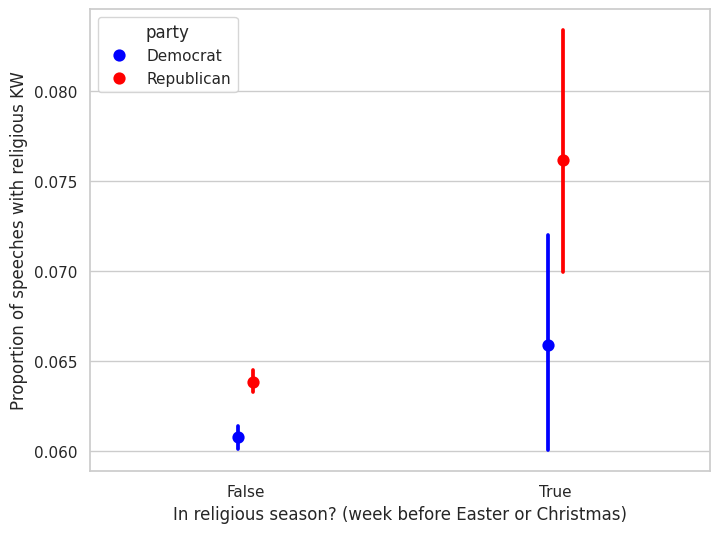

In [116]:
# plot before_relig vs. lexical

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.pointplot(x="before_relig", y="binary_lex", data=df, hue='party', palette={'Democrat': 'blue', 'Republican': 'red'}, linestyle='none', dodge=True)
ax.set_xlabel("In religious season? (week before Easter or Christmas)")
ax.set_ylabel("Proportion of speeches with religious KW")
plt.show()

Lexical score and religious season over time


/home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


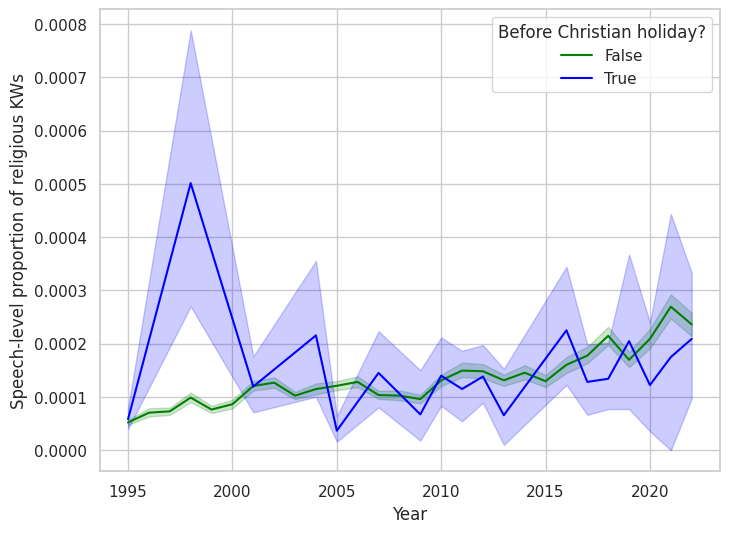

In [ ]:
# relationship between lexical score and religious season over time
print("Lexical score and religious season over time")
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.lineplot(x="year", y="lexical", data=df, hue='before_relig', palette={False: 'green', True: 'blue'})
plt.legend(title="Before Christian holiday?")
ax.set_xlabel("Year")
ax.set_ylabel("Speech-level proportion of religious KWs")
plt.show()

In [ ]:
df.head()

,bio_id,congress_num,year,date,chamber,speaker,text,month_code,month,gender,...,old_binary_lex,lr_label_prop_religious,max_lr_prob,avg_lr_prob,in_week_before_christmas,in_week_before_easter,before_relig,in_two_weeks_after_9_11,week_idx,in_official
0,L000397,116,2019,2019-01-04,House,Ms. LOFGREN,"Ms. LOFGREN. Madam Speaker, I rise today to ho...",1,1,F,...,True,0.0,0.025757,0.025757,False,False,False,False,1,False
1,W000804,116,2019,2019-01-04,House,Mr. WITTMAN,"Mr. WITTMAN. Madam Speaker, I was not present ...",1,1,M,...,False,0.0,0.000569,0.000569,False,False,False,False,1,False
2,S001201,116,2019,2019-01-04,House,Mr. SUOZZI,"Mr. SUOZZI. Madam Speaker, today is former Con...",1,1,M,...,False,0.0,0.000002,0.000002,False,False,False,False,1,False
3,S001199,116,2019,2019-01-04,House,Mr. SMUCKER,"Mr. SMUCKER. Madam Speaker, I regret I was una...",1,1,M,...,False,0.0,0.006180,0.006180,False,False,False,False,1,False
4,U000031,116,2019,2019-01-04,House,Mr. UPTON,"Mr. UPTON. Madam Speaker, I was unavoidably de...",1,1,M,...,False,0.0,0.024203,0.024203,False,False,False,False,1,False


In [117]:
# aggregate to week averages
print("Aggregating to week averages")
week_avg = df.groupby(['year', 'week_idx']).agg({'lexical': 'mean', 'binary_lex': 'mean', 'in_two_weeks_after_9_11': 'any', 'in_official': 'first'}).reset_index()

Aggregating to week averages


In [118]:
week_avg

,year,week_idx,lexical,binary_lex,in_two_weeks_after_9_11,in_official
0,1995,1,0.000222,0.060090,False,False
1,1995,2,0.000085,0.041530,False,False
2,1995,3,0.000144,0.049757,False,False
3,1995,4,0.000129,0.041581,False,False
4,1995,5,0.000108,0.038402,False,False
...,...,...,...,...,...,...
1156,2022,48,0.000732,0.121086,False,False
1157,2022,49,0.001082,0.131994,False,False
1158,2022,50,0.000427,0.085921,False,False
1159,2022,51,0.000313,0.062411,False,False


In [120]:
palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=3, rc={'figure.figsize':(12,10)}, style='whitegrid')

Proportion of religious KWs over time


/tmp/ipykernel_21806/1351951196.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x="week_idx", y="lexical", data=week_avg_2001, hue='year', palette=palette, alpha=1, ci=None)
/home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/tmp/ipykernel_21806/1351951196.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="week_idx", y="lexical", data=week_avg_no_2001, hue='year', palette=palette, alpha=0.4, ci=None)
/home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a leng

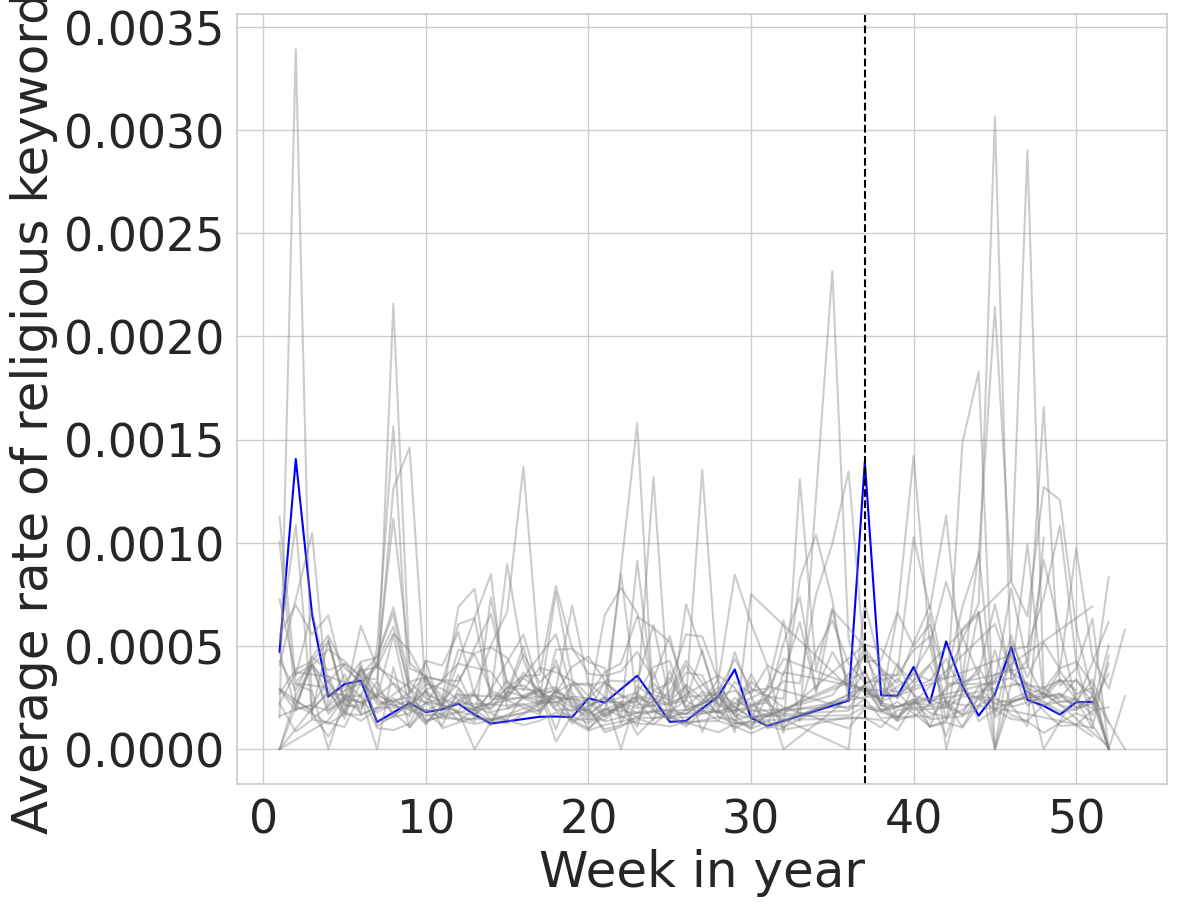

In [121]:
# for every year, plot the proportion of religious KWs as line
# highlight 2001 line


plt.figure(figsize=(12, 10))
print("Proportion of religious KWs over time")
palette = {}
for year in df['year'].unique():
    if year == 2001:
        palette[year] = 'blue'
    else:
        palette[year] = 'grey'
alphas = {}
for year in df['year'].unique():
    if year == 2001:
        alphas[year] = 1
    else:
        alphas[year] = 0.7

week_avg['alpha'] = week_avg['year'].apply(lambda x: alphas[x])
week_avg_no_2001 = week_avg[week_avg['year'] != 2001]
week_avg_2001 = week_avg[week_avg['year'] == 2001]
ax = sns.lineplot(x="week_idx", y="lexical", data=week_avg_2001, hue='year', palette=palette, alpha=1, ci=None)
sns.lineplot(x="week_idx", y="lexical", data=week_avg_no_2001, hue='year', palette=palette, alpha=0.4, ci=None)
ax.set_xlabel("Week in year")
ax.set_ylabel("Average rate of religious keywords")
plt.legend().remove()
plt.axvline(x=37, color='black', linestyle='--') # 37th week of 2001 is when 9/11 happened
plt.annotate('9/11', xy=(37, 0.05), xytext=(37, 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12, ha='center')

plt.show()


In [ ]:
df.head()

,bio_id,congress_num,year,date,chamber,speaker,text,month_code,month,gender,...,old_binary_lex,lr_label_prop_religious,max_lr_prob,avg_lr_prob,in_week_before_christmas,in_week_before_easter,before_relig,in_two_weeks_after_9_11,week_idx,in_official
0,L000397,116,2019,2019-01-04,House,Ms. LOFGREN,"Ms. LOFGREN. Madam Speaker, I rise today to ho...",1,1,F,...,True,0.0,0.025757,0.025757,False,False,False,False,1,False
1,W000804,116,2019,2019-01-04,House,Mr. WITTMAN,"Mr. WITTMAN. Madam Speaker, I was not present ...",1,1,M,...,False,0.0,0.000569,0.000569,False,False,False,False,1,False
2,S001201,116,2019,2019-01-04,House,Mr. SUOZZI,"Mr. SUOZZI. Madam Speaker, today is former Con...",1,1,M,...,False,0.0,0.000002,0.000002,False,False,False,False,1,False
3,S001199,116,2019,2019-01-04,House,Mr. SMUCKER,"Mr. SMUCKER. Madam Speaker, I regret I was una...",1,1,M,...,False,0.0,0.006180,0.006180,False,False,False,False,1,False
4,U000031,116,2019,2019-01-04,House,Mr. UPTON,"Mr. UPTON. Madam Speaker, I was unavoidably de...",1,1,M,...,False,0.0,0.024203,0.024203,False,False,False,False,1,False


Proportion of speeches that include a religious keyword


/tmp/ipykernel_21806/2287590210.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x="week_idx", y="binary_lex_perc", data=week_avg_2001, hue='year', palette=palette, alpha=1, ci=None)
/home/laviniad/miniconda3/envs/sermons/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


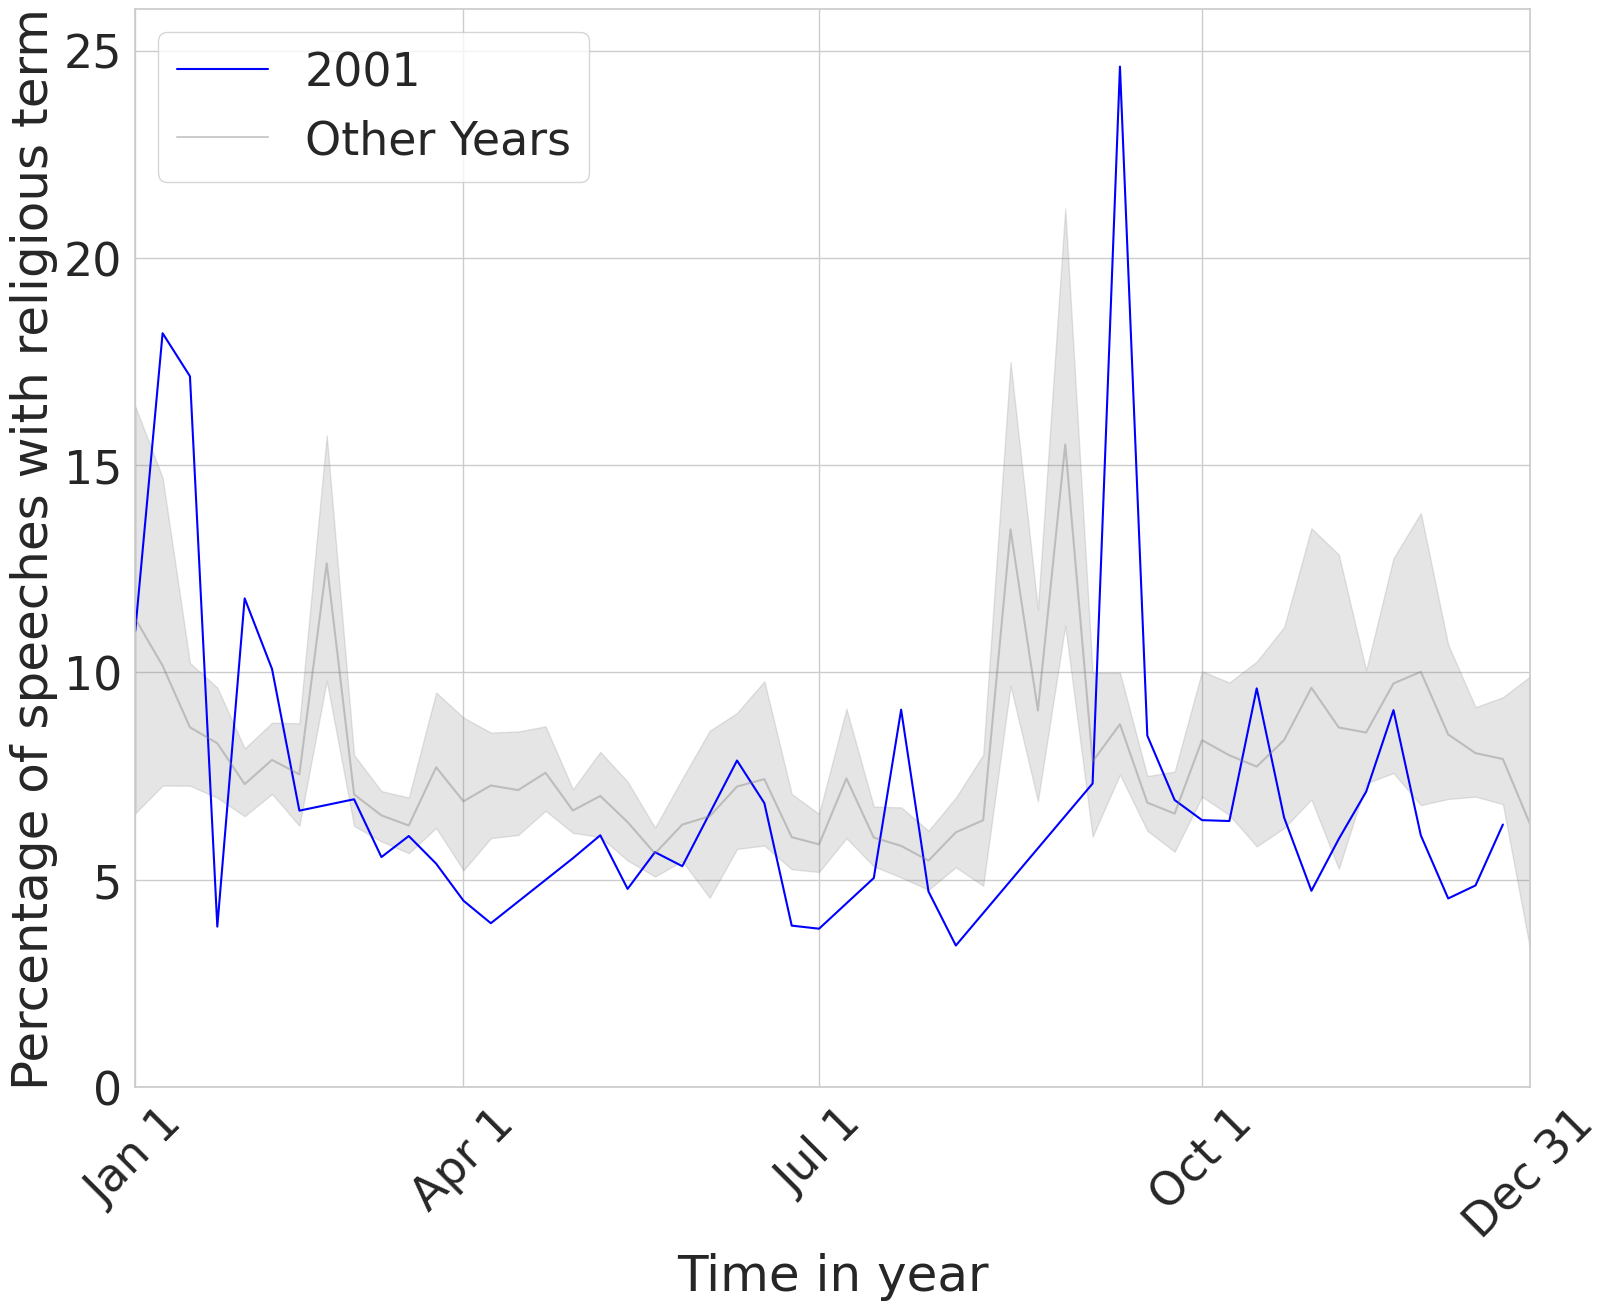

In [122]:
# for every year, plot the proportion of religious KWs as line
# highlight 2001 line
palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=3, rc={'figure.figsize':(18,14), 'font.weight': 'normal'}, style='whitegrid')

print("Proportion of speeches that include a religious keyword")
palette = {}
for year in df['year'].unique():
    if year == 2001:
        palette[year] = 'blue'
    else:
        palette[year] = 'grey'
alphas = {}
for year in df['year'].unique():
    if year == 2001:
        alphas[year] = 1
    else:
        alphas[year] = 0.6

week_avg['binary_lex_perc'] = week_avg['binary_lex'] * 100
week_avg['alpha'] = week_avg['year'].apply(lambda x: alphas[x])
week_avg_no_2001 = week_avg[week_avg['year'] != 2001].query("week_idx < 53")
week_avg_2001 = week_avg[week_avg['year'] == 2001]
ax = sns.lineplot(x="week_idx", y="binary_lex_perc", data=week_avg_2001, hue='year', palette=palette, alpha=1, ci=None)
ax2 = sns.lineplot(x="week_idx", y="binary_lex_perc", data=week_avg_no_2001, color='grey', alpha=0.4, label='Other Years')

# needed for legend construction
handles1, labels1 = ax.get_legend_handles_labels()
#handles2, labels2 = ax2.get_legend_handles_labels()
#handles = handles1 + handles2
#labels = labels1 + labels2

ax.set_xlabel("Time in year")
#plt.axvline(x=37, color='black', linestyle='--') # 37th week of 2001 is when 9/11 happened
ax.set_ylabel("Percentage of speeches with religious term")

plt.xlim(1, 52)
plt.ylim(0, 26)
# Add x-axis labels
# 2001-specific
week_labels = ['Jan 1', 'Apr 1', 'Jul 1', 'Oct 1', 'Dec 31']
week_positions = [1, 13, 26, 40, 52]
plt.xticks(week_positions, week_labels, rotation=45)
ax.legend(handles=handles1, labels=labels1, loc='upper left')
plt.savefig("/home/laviniad/projects/religion_in_congress/notebooks/plots/new_plots/9_11_kw_use.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# BR analyses

In [ ]:
# insert relevant code from hypothesis 2 notebook

import pickle as pkl
import re
from data.bible_utils import comp_bible_helper
import nltk

MPNET_RESULTS = '/data/laviniad/sermons-ir/modeling/mpnet_results'
with open(MPNET_RESULTS + "/data.pkl", "rb") as f:
    data = pkl.load(f)

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

bible_df = comp_bible_helper()
pop_verses = pd.read_csv('/home/laviniad/projects/religion_in_congress/data/most_popular_verses.csv')
n = 500 # VERY generous
pop_citations = list(pop_verses['verse'].iloc[1:n+1])
bible_df['King James Bible'] = bible_df['King James Bible'].apply(remove_tags) # KJV in this df has italics etc
bible_df['Verse'] = bible_df['Verse'].apply(lambda x: x.lower())
limited_bible_df = bible_df[bible_df['Verse'].apply(lambda x: x in pop_citations)]
limited_verses = limited_bible_df['King James Bible']
verse_df = [{'text': t['King James Bible'], 'citation': t['citation']} for idx,t in limited_bible_df.iterrows()]
verse_df = pd.DataFrame(verse_df)
print(f"Number of verses: {len(verse_df.index)}")
limited_verse_to_citation = dict(zip(limited_verses, limited_bible_df['Verse']))
limited_citation_to_verse = {v.lower(): k for k,v in limited_verse_to_citation.items()}

br_df = pd.read_csv(MPNET_RESULTS + '/results.csv')
br_df['congress_idx'] = br_df['congress_idx'].apply(lambda x: x.replace('tensor(', '').replace(')', '')).apply(int)

def get_year(congress_idx):
    if congress_idx in df.index:
        return df.loc[(congress_idx,'year')]
    else:
        return 'unlabeled'

br_df['year'] = br_df['congress_idx'].apply(get_year)

def get_party(congress_idx):
    if congress_idx in df.index:
        return df.loc[(congress_idx,'party')]
    else:
        return 'unlabeled'

br_df['party'] = br_df['congress_idx'].apply(get_party)

br_df['is_rep'] = (br_df['party'] == 'Republican').apply(int)

def get_speaker(congress_idx):
    idx_key = congress_idx
    if idx_key in df.index:
        speaker = df.loc[idx_key]['speaker']
        return speaker
    else:
        return 0

br_df['speaker'] = br_df['congress_idx'].progress_apply(get_speaker)

def get_date(congress_idx):
    idx_key = congress_idx
    if idx_key in df.index:
        speaker = df.loc[idx_key]['date']
        return speaker
    else:
        return 0

br_df['date'] = br_df['congress_idx'].progress_apply(get_date)

filtered = br_df[br_df['cosine_similarity'] > 0.8]

Number of verses: 499


  0%|          | 0/2188231 [00:00<?, ?it/s]

  0%|          | 0/2188231 [00:00<?, ?it/s]

In [ ]:
filtered = br_df[br_df['cosine_similarity'] > 0.8]

In [ ]:
format='%Y-%m-%d %H:%M:%S'

def get_date_obj(x):
    if x == 0:
        return None
    else:
        return pd.to_datetime(str(x))
    return None

filtered['date'] = filtered['date'].apply(get_date_obj)

/tmp/ipykernel_3195938/2510318291.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['date'] = filtered['date'].apply(get_date_obj)


In [ ]:
filtered['count'] = 1

/tmp/ipykernel_3195938/2907659009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['count'] = 1


In [ ]:
date_citations = filtered.groupby('date')['count'].sum()

# Find the dates with the most citations
dates_with_most_citations = date_citations.nlargest(5)

# Print the dates with the most citations
print(dates_with_most_citations)

date
2018-12-12    36
2007-11-05    10
1995-09-07     8
1998-07-28     8
2006-04-27     8
Name: count, dtype: int64


In [ ]:
# rank speakers by number of citations

speaker_citations = filtered.groupby('speaker')['count'].sum()
# remove PRESIDING OFFICER
#speaker_citations = speaker_citations.drop('The PRESIDING OFFICER')
speaker_citations = speaker_citations.nlargest(10)
print(speaker_citations)

speaker
0                           62
Mr. BYRD                    55
Mr. GOHMERT                 39
Mr. RUSSELL                 37
Ms. JACKSON-LEE of Texas    16
Mr. EMERSON                 15
Mr. BARTLETT of Maryland    14
Mr. INHOFE                  14
Mr. KUCINICH                14
Mr. ADERHOLT                10
Name: count, dtype: int64


In [ ]:
# top for emerson
allen = filtered[filtered['speaker'] == 'Mr. ALLEN']

In [ ]:
br_df['date'] = pd.to_datetime(br_df['date'])

In [ ]:
br_df['date']

0         2019-01-04
1         2019-01-04
2         2019-01-04
3         2019-01-04
4         2019-01-04
             ...    
2188226   1970-01-01
2188227   1970-01-01
2188228   1970-01-01
2188229   2019-01-02
2188230   2019-01-02
Name: date, Length: 2188231, dtype: datetime64[ns]

In [ ]:
# count number of citations from holy weeks
def in_week_before_christmas(date):
    print(date)
    if date is not None:
        return (date.month == 12) and (date.day > 18) and (date.day < 26)
    return False

print(filtered['date'].isna().sum())
filtered.dropna(subset=['date'], inplace=True)
filtered['in_week_before_christmas'] = filtered['date'].apply(in_week_before_christmas)
filtered['in_week_before_easter'] = filtered['date'].apply(in_week_before_easter)

62
2019-01-10 00:00:00
2019-01-28 00:00:00
2019-03-11 00:00:00
2019-05-01 00:00:00
2019-05-16 00:00:00
2019-05-17 00:00:00
2019-05-17 00:00:00
2019-06-05 00:00:00
2019-07-12 00:00:00
2019-07-16 00:00:00
2019-09-11 00:00:00
2019-11-19 00:00:00
2019-11-20 00:00:00
2019-11-20 00:00:00
2019-11-20 00:00:00
2019-11-21 00:00:00
2019-12-05 00:00:00
2019-12-19 00:00:00
2019-12-19 00:00:00
2019-12-19 00:00:00
2020-01-09 00:00:00
2020-01-15 00:00:00
2020-01-15 00:00:00
2020-03-10 00:00:00
2020-07-22 00:00:00
2020-07-22 00:00:00
2020-07-22 00:00:00
2020-07-22 00:00:00
2020-07-22 00:00:00
2020-09-17 00:00:00
2020-12-03 00:00:00
2020-12-09 00:00:00
2020-12-09 00:00:00
2020-12-09 00:00:00
2020-12-09 00:00:00
2020-12-09 00:00:00
2020-12-09 00:00:00
2020-12-17 00:00:00
2020-12-18 00:00:00
2020-12-18 00:00:00
2009-01-21 00:00:00
2009-05-04 00:00:00
2009-05-05 00:00:00
2009-05-14 00:00:00
2009-05-14 00:00:00
2009-05-14 00:00:00
2009-05-14 00:00:00
2009-05-14 00:00:00
2009-05-14 00:00:00
2009-06-09 00:00:

/tmp/ipykernel_3195938/38478111.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.dropna(subset=['date'], inplace=True)
/tmp/ipykernel_3195938/38478111.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['in_week_before_christmas'] = filtered['date'].apply(in_week_before_christmas)
/tmp/ipykernel_3195938/38478111.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [ ]:
filtered['in_relig_week'] = filtered['in_week_before_christmas'] | filtered['in_week_before_easter']

/tmp/ipykernel_3195938/2790142544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['in_relig_week'] = filtered['in_week_before_christmas'] | filtered['in_week_before_easter']


In [ ]:
set(filtered['in_relig_week'])

{False, True}

In [ ]:
agg = filtered.groupby('in_relig_week').agg({'count': 'sum'})

In [ ]:
print(agg['count'][True] / agg['count'].sum())

0.017811704834605598


In [ ]:
len(filtered)

786

In [ ]:
import json

path = '/data/laviniad/congress_bioguides.jsonlist'
obj_list = {}

with open(path, 'r') as f:
    for l in f.readlines():
        obj = json.loads(l.strip())
        # get most recent term
        year_died = None
        if "deathDate" in obj.keys():
            year_died = obj["deathDate"]
        if (year_died == None) or (year_died == "") or (not (int(year_died[:4]) < 1995)): # hasn't died before 1995
            party = obj["party"]
            most_recent = obj['jobPositions'][-1] # resulting obj has "job" field and "congressAffiliation" field, which itself has "congress" and "partyAffiliation" and "represents"
            if "represents" in most_recent["congressAffiliation"].keys():
                state = most_recent["congressAffiliation"]["represents"]["regionCode"]
            else:
                print(most_recent["congressAffiliation"])
                state = "unlabeled"
            chamber = most_recent["job"]["name"]
            full_name = obj["givenName"] + " " + obj["familyName"]

            most_recent = most_recent["congressAffiliation"]["congress"]
            most_early = obj["jobPositions"][0]["congressAffiliation"]["congress"]

            if "startDate" in most_early.keys():
                if "endDate" in most_recent.keys():
                    time_in_congress = "(" + most_early["startDate"][:4] + "-" + most_recent["endDate"][:4] + ")"
                else:
                    time_in_congress = "(" + most_early["startDate"][:4] + "-" + "2024" + ")"
            else:
                print("***")
                time_in_congress = "(unlabeled)"

            obj_list[obj["usCongressBioId"]] = {"full_name": full_name, "party": party, "state": state, "chamber": chamber, "time_in_congress": time_in_congress}

{'congress': {'name': 'The 105th United States Congress', 'congressNumber': 105, 'congressType': 'USCongress', 'startDate': '1997-01-03', 'endDate': '1999-01-03'}, 'partyAffiliation': [{'party': {'name': 'Republican'}, 'startCirca': False, 'endCirca': False}], 'caucusAffiliation': [{'party': {'name': 'Republican'}, 'startCirca': False, 'endCirca': False}]}
{'congress': {'congressNumber': 118, 'congressType': 'USCongress', 'name': 'The 118th United States Congress', 'startDate': '2023-01-03'}, 'partyAffiliation': [{'party': {'name': 'Republican'}, 'startCirca': False, 'endCirca': False}]}
{'congress': {'name': 'The 101st United States Congress', 'congressNumber': 101, 'congressType': 'USCongress', 'startDate': '1989-01-03', 'endDate': '1991-01-03'}, 'partyAffiliation': [{'party': {'name': 'Democrat'}, 'startCirca': False, 'endCirca': False}], 'caucusAffiliation': [{'party': {'name': 'Democrat'}, 'startCirca': False, 'endCirca': False}]}
{'congress': {'name': 'The 103rd United States Con

In [ ]:
def get_bio_id(congress_idx):
    idx_key = congress_idx
    if idx_key in df.index:
        speaker = df.loc[idx_key]['bio_id']
        return speaker
    else:
        return 0

filtered['bio_id'] = filtered['congress_idx'].apply(get_bio_id)

/tmp/ipykernel_3195938/162371321.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['bio_id'] = filtered['congress_idx'].apply(get_bio_id)


In [ ]:
filtered['full_name'] = filtered['bio_id'].progress_apply(lambda x: obj_list.get(x, {"full_name": "unknown"})["full_name"])
filtered['time_in_congress'] = filtered['bio_id'].progress_apply(lambda x: obj_list.get(x, {"time_in_congress": "unknown"})["time_in_congress"])

def get_min_and_max(time_in_congress):
    return [int(e) for e in time_in_congress[1:-1].split("-")]

filtered['year_min'] = filtered['time_in_congress'].apply(lambda x: get_min_and_max(x)[0])
filtered['year_max'] = filtered['time_in_congress'].apply(lambda x: get_min_and_max(x)[1])

  0%|          | 0/786 [00:00<?, ?it/s]

/tmp/ipykernel_3195938/605549570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['full_name'] = filtered['bio_id'].progress_apply(lambda x: obj_list.get(x, {"full_name": "unknown"})["full_name"])


  0%|          | 0/786 [00:00<?, ?it/s]

/tmp/ipykernel_3195938/605549570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['time_in_congress'] = filtered['bio_id'].progress_apply(lambda x: obj_list.get(x, {"time_in_congress": "unknown"})["time_in_congress"])
/tmp/ipykernel_3195938/605549570.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['year_min'] = filtered['time_in_congress'].apply(lambda x: get_min_and_max(x)[0])
/tmp/ipykernel_3195938/605549570.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [ ]:
sample = filtered[['text', 'most_similar_verse', 'verse_citation', 'cosine_similarity', 'year', 'full_name', 'party']].sample(15)

In [ ]:
party_func = lambda x: x[0] # gets first char
CONST = 150

def text_func(t):
    if len(t) > CONST:
        return t[:CONST] + "..."
    return t

sample.to_latex(index=False, float_format="%.2f", formatters={"party": party_func, "text": text_func,
                                                              "most_similar_verse": text_func}, header=True)

"\\begin{tabular}{lllrlll}\n\\toprule\ntext & most_similar_verse & verse_citation & cosine_similarity & year & full_name & party \\\\\n\\midrule\nAnd this is the condemnation: that light is come unto the world, and men loved darkness rather than light, because their deeds were evil. & And this is the condemnation, that light is come into the world, and men loved darkness rather than light, because their deeds were evil. & John 3:19 & 0.98 & 1997 & William Barrett & R \\\\\nAnd He said unto them, Go ye into the world, and preach the gospel to every creature. & And he said unto them, Go ye into all the world, and preach the gospel to every creature. & Mark 16:15 & 0.99 & 2017 & Bennie Thompson & D \\\\\nGuide us, thine own, aright Teach us by day, by night, To keep thine honor bright, For thee to fight. & Obey them that have the rule over you, and submit yourselves: for they watch for your souls, as they that must give account, that they may do it with ... & Hebrews 13:17 & 0.82 & 2019 &